## Matching Estimator

So far we have seen how to deal with Confounding Bias: According to our techniques, we can either control for the confounder by adding them as covariates to our regression model or take advantage of variables that are good predictors of treatment and affect the outcome only through the treatment (aka Instrumental Variables).

Now it's time for us to focus on **Selection Bias** as well. It might be the case that some confounders/covariates make treated and untreated NOT initially comparable. For example, imagine a situation where we want to estimate the effect of a medication on the recovery of a given disease. It can happen that we find out that the medicine acts in the opposite direction rather than what we'd previously assumed: Medication actually decreases recovery rates. Counterintuitive, isn't it? But then we discover that patients in more severe cases preferrably received the medicine; also, older people tend to get the medicine more often. Therefore, we need to come up with a way of **matching each treated unit with its most similar untreated one**. Under these circumstances, we would have a fair scenario: if an aged person with a severe case gets the medicine, and another aged one also in severe conditions does not receive it, then we can compare the difference between them. And we follow this same approach for the whole dataset.

### Propensity Score

Our main goal is to define a **similarity measure** that helps us compare how units are close to each other. Then a match, such as the nearest neighbor to the unit of interest, naturally follows.

In our case, we will use `Propensity Score` - that is, the conditional probability of treatment. Given a set of covariates, we can predict the probability with which each individual will be in the treated group. It comes from the fact that it is not necessary to direct control for confounders to achieve conditional independence: *It is sufficient to control for the propensity score*.

$(Y_{0}, Y_{1}) \perp T|X$ ~ $(Y_{0}, Y_{1}) \perp T|P(X)$

If we take 2 individuals - 1 from the treated and 1 from the control groups - but with the same propensity score, the only reason why one received the treatment and the other didn't is **random assignment**. Therefore, **by matching individuals based on their propensity score, we move towards our gold standard of RCTs**.

### How do we estimate propensity score?

We rely on a *logistic regression* to predict binary treatment on a set of covariates: $P(T|X)$. Then, based on the score, we simply match individuals.

But before proceeding to the actual estimation of ATE, it is quite important to check **whether the treated and untreated distributions overlap**. Due to the **Positivity Assumption**, $P(T|X) > 0$ - ie, everyone needs to have at least the slightest chance of receiving the treatment and of not receiving it.

Mathematically, we can write:

$\mathbb{E}[Y|X, T=1] - \mathbb{E}[Y|X, T=0] = \mathbb{E}[\frac{Y}{P(x)}|X, T=1]P(x) - \mathbb{E}[\frac{Y}{1-P(x)}|X, T=1](1-P(x))$

What we are basically doing is **weighting by the inverse of the propensity, for treated, and by (1-propensity) for the untreated. Why does it make sense? Well, if someone has a very low probability of treatment, this individual looks much more like the untreated. And if they actually received treatment, then they should have a higher weight for the computation.

In a sense, we are synthetically creating a new population of the same size where everyone is treated. Hence, we can take advantage of the binary treatment, and write:

$\mathbb{E}[Y\frac{T - P(x)}{P(x)(1-P(x))}|X]$

For $T=1$, we have $\mathbb{E}[\frac{Y}{P(x)}|X]$, whereas, for $T=0$, $-\mathbb{E}[\frac{Y}{1-P(x)}|X]$. Hence, we have our aimed subtraction with the corresponding weighting for treated and untreated.

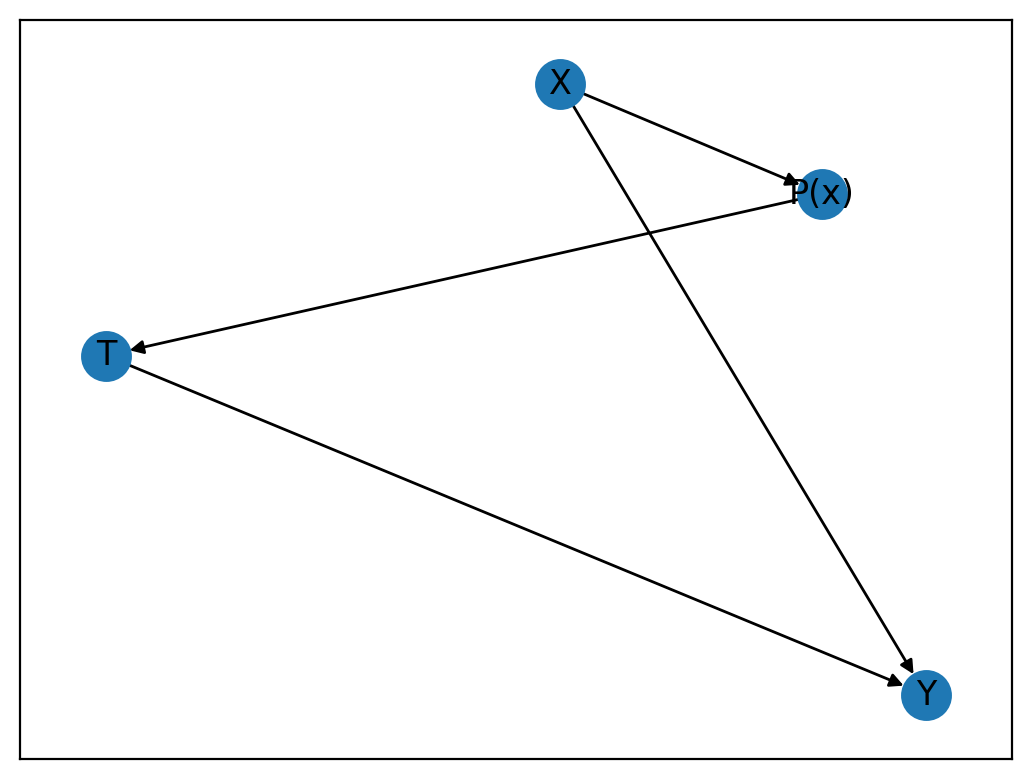

In [1]:


import networkx as nx

g = nx.DiGraph()
g.add_edge("X", "P(x)")
g.add_edge("P(x)", "T")
g.add_edge("T", "Y")
g.add_edge("X", "Y")
nx.draw_networkx(g, with_labels=True)

### Libraries

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from causalinference import CausalModel

from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
style.use("fivethirtyeight")

import warnings
warnings.filterwarnings("ignore")

### Data

For the sake of simplicity and learning, we are going to use a dataset to answer the following causal question: *Is smoking associated with psychological distress?*.

In this case, `smoker` is our treatment variable, while `psyc_distress` is our outcome variable. The main idea is that we will match smokers and non-smokers according to a set of covariates, including `sex` (0: Female; 1: Male), `indigeneity` (0: Non-indigenous; 1: indigenous), `high_school` (0: not finished high school; 1: finished high school), `partnered` (0: not partnered; 1: partnered), `remoteness` (0: major cities; 1: inner regional; 2: outer regional), `language` (0: non-English speaking; 1: English speaking), `age` and `risky_alcohol` (alcohol use - 0: not risky; 1: risky).

In [3]:
df = pd.read_csv("../data/smoking_psyc_distress.csv",)
df.head()

,sex,indigeneity,high_school,partnered,remoteness,language,smoker,risky_alcohol,psyc_distress,age
0,0,0,1,1,0,1,0,0,13,63
1,0,0,1,1,0,1,0,1,11,48
2,0,0,0,0,0,1,0,1,11,54
3,1,0,1,1,0,1,0,1,12,50
4,0,0,0,1,1,1,0,1,10,67


Some basic definitions:

In [4]:
Y = "psyc_distress"
T = "smoker"
X = [c for c in df.columns if not c in [Y, T]]

From the visualizations below, we can see that men, high-school dropouts and indigenous people tend to smoke more. Initially, it seems that these groups also present higher psychological distress. However, for women, it seems that it is quite the opposite, since they have slightely higher distress.

This is a perfect scenario for us to apply matching techniques, once we need to make our groups comparable.

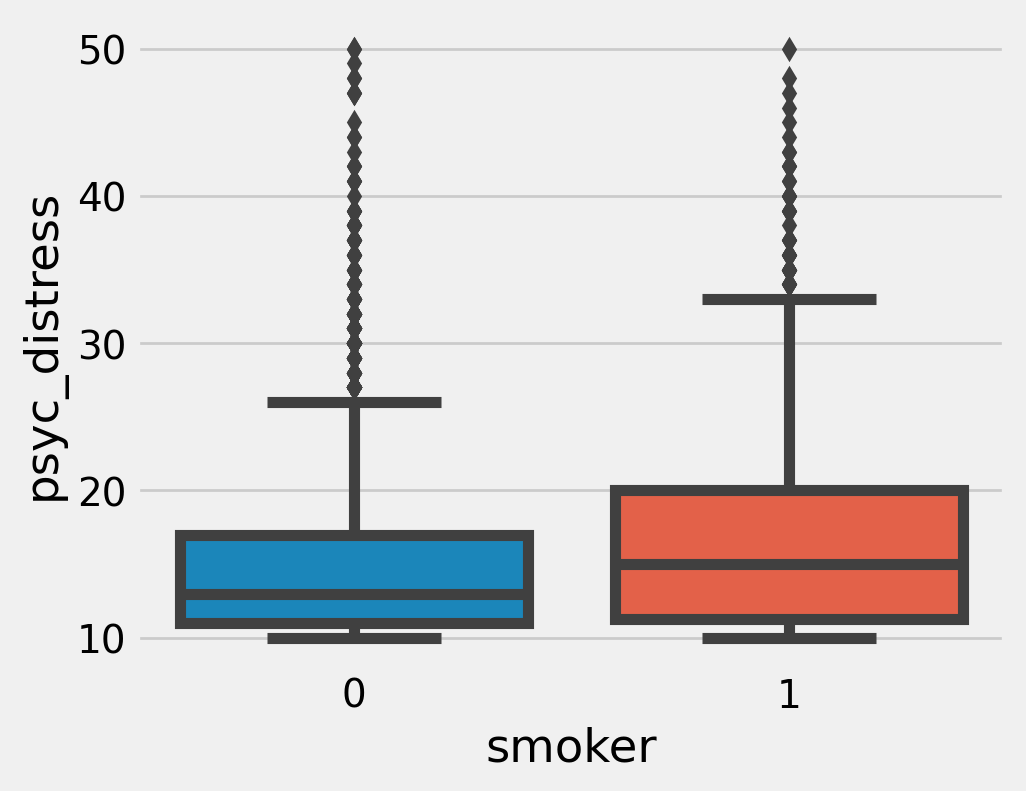

In [5]:
_, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.boxplot(data=df, y=Y, x=T, ax=ax)
plt.show()

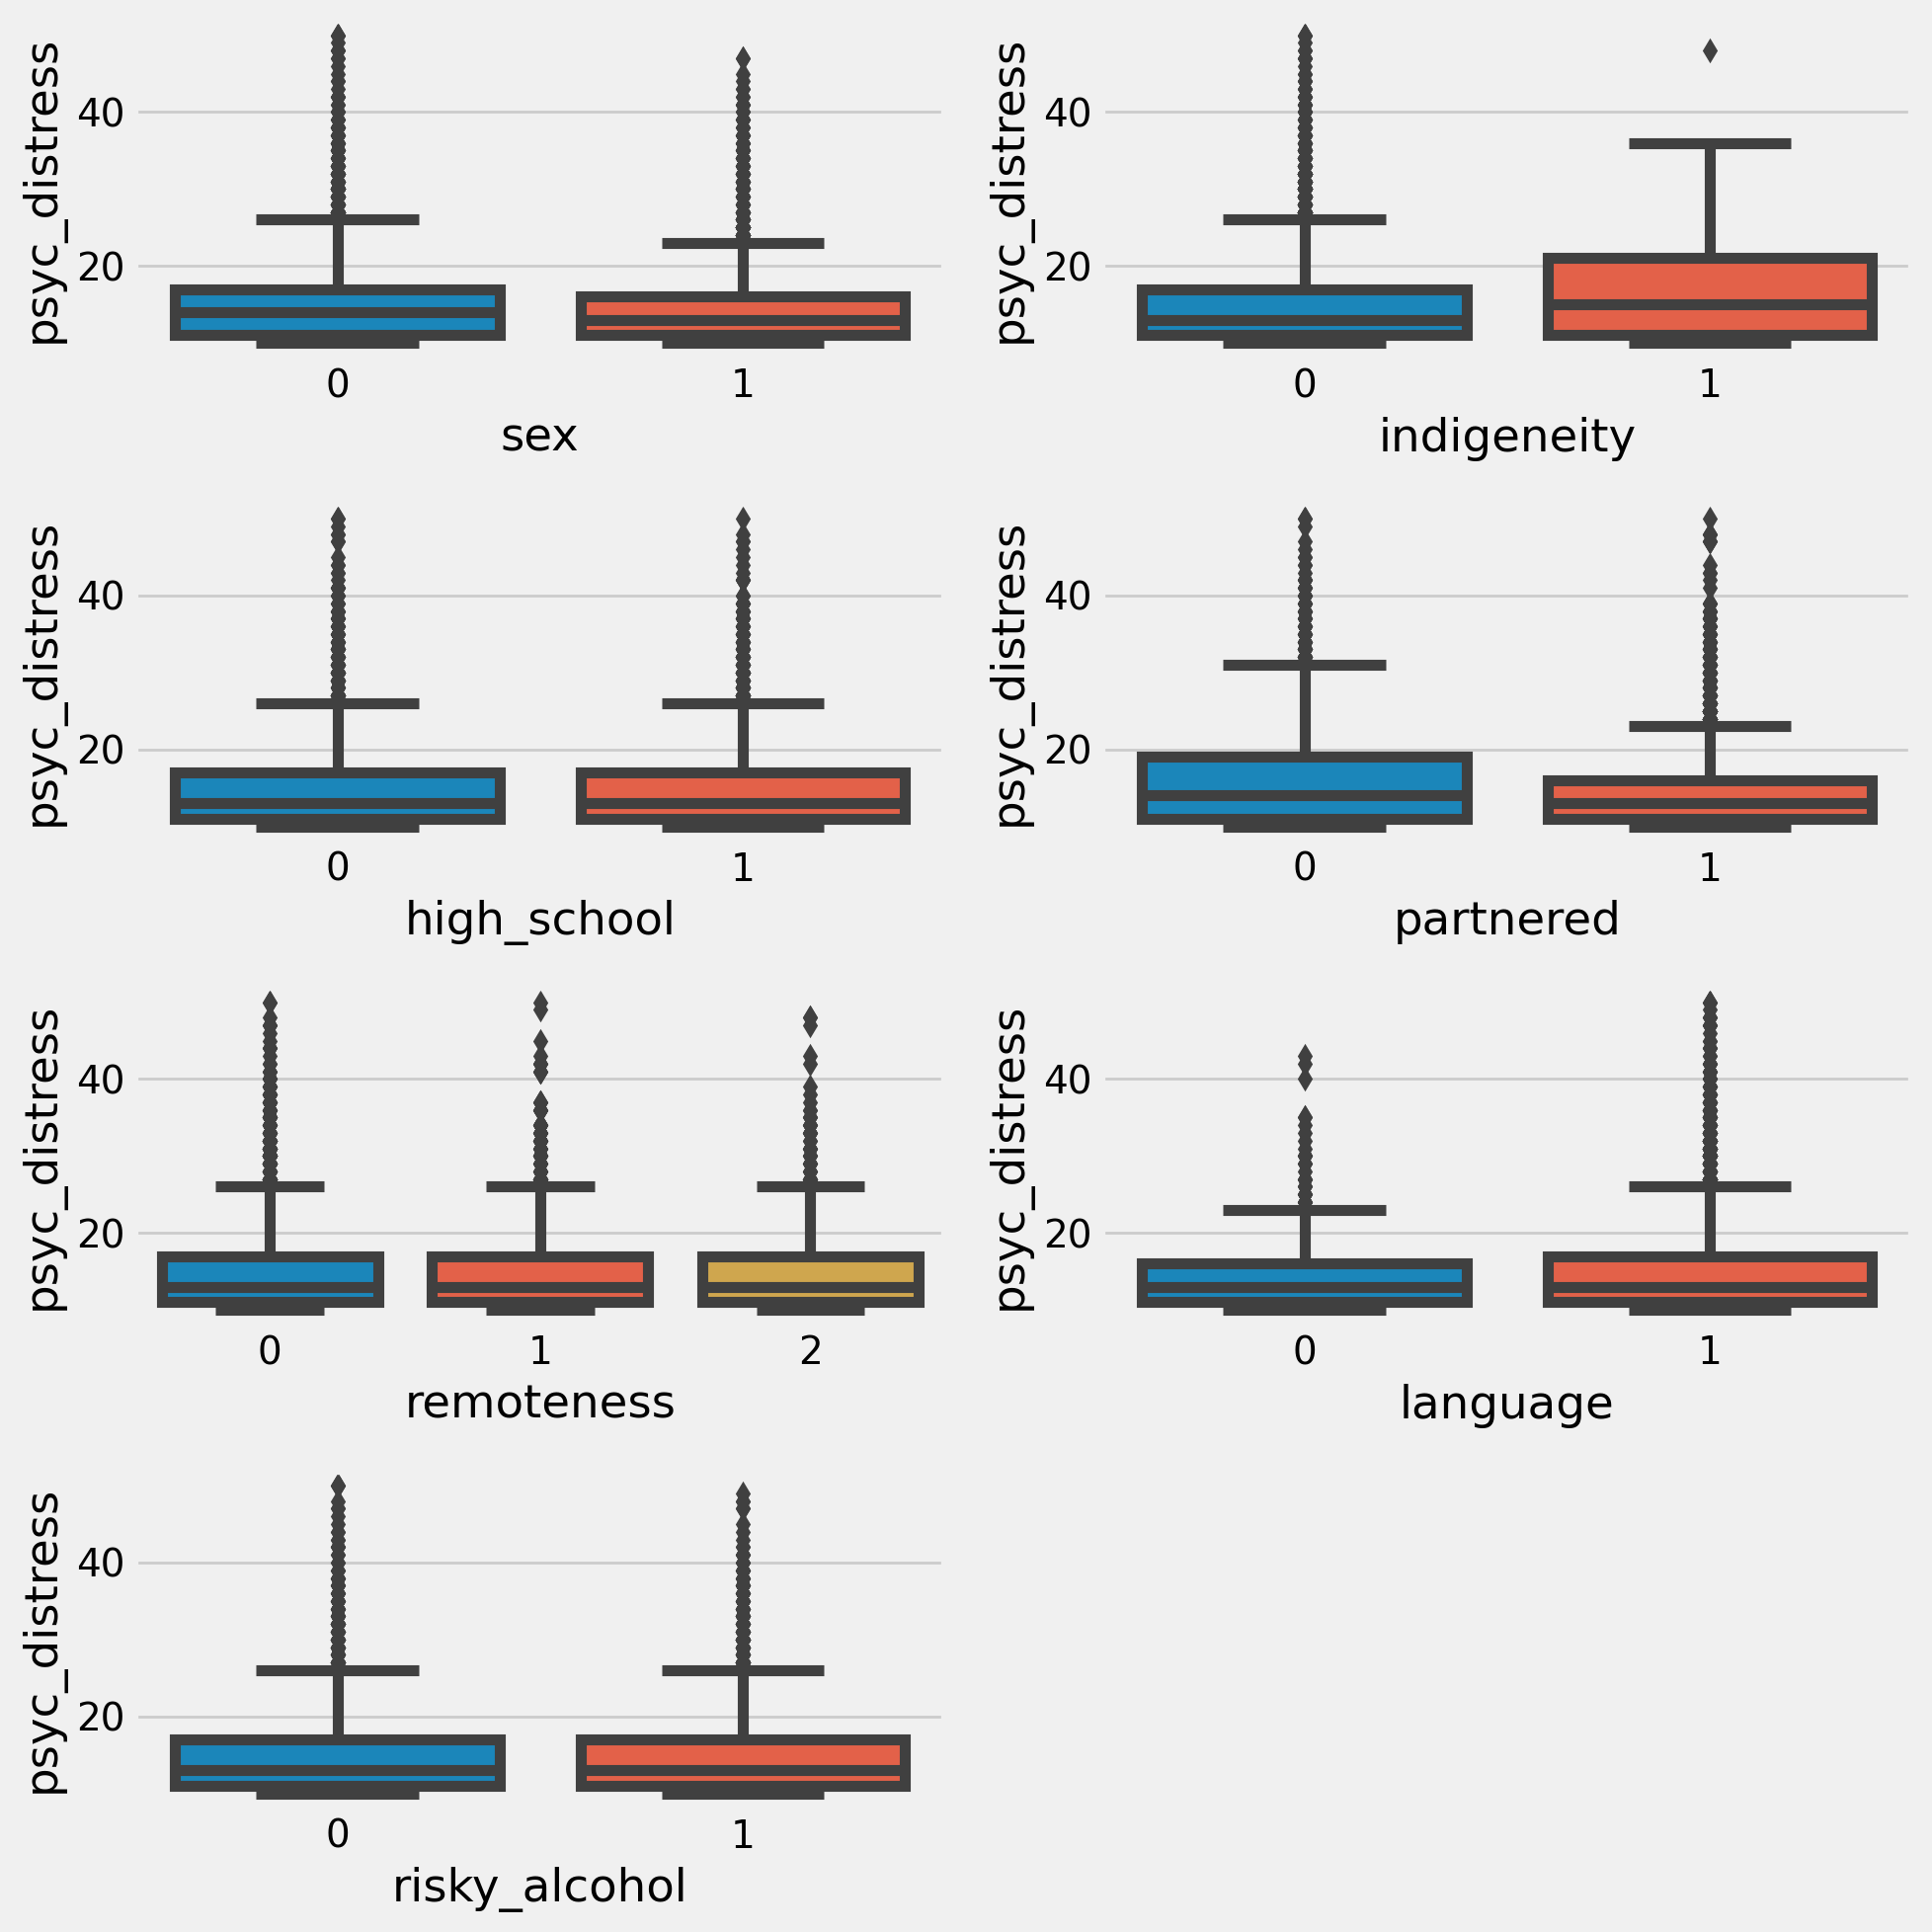

In [6]:
cat_X = [
    c for c in X if c!="age"
]

ncols = 2
nrows = int(np.ceil(len(cat_X) / ncols))

_ = plt.figure(figsize=(10, 10))

for i, x in enumerate(cat_X):
    ax = plt.subplot(nrows, ncols, i+1)
    sns.boxplot(data=df, y=Y, x=x, ax=ax)

plt.tight_layout()
plt.show()

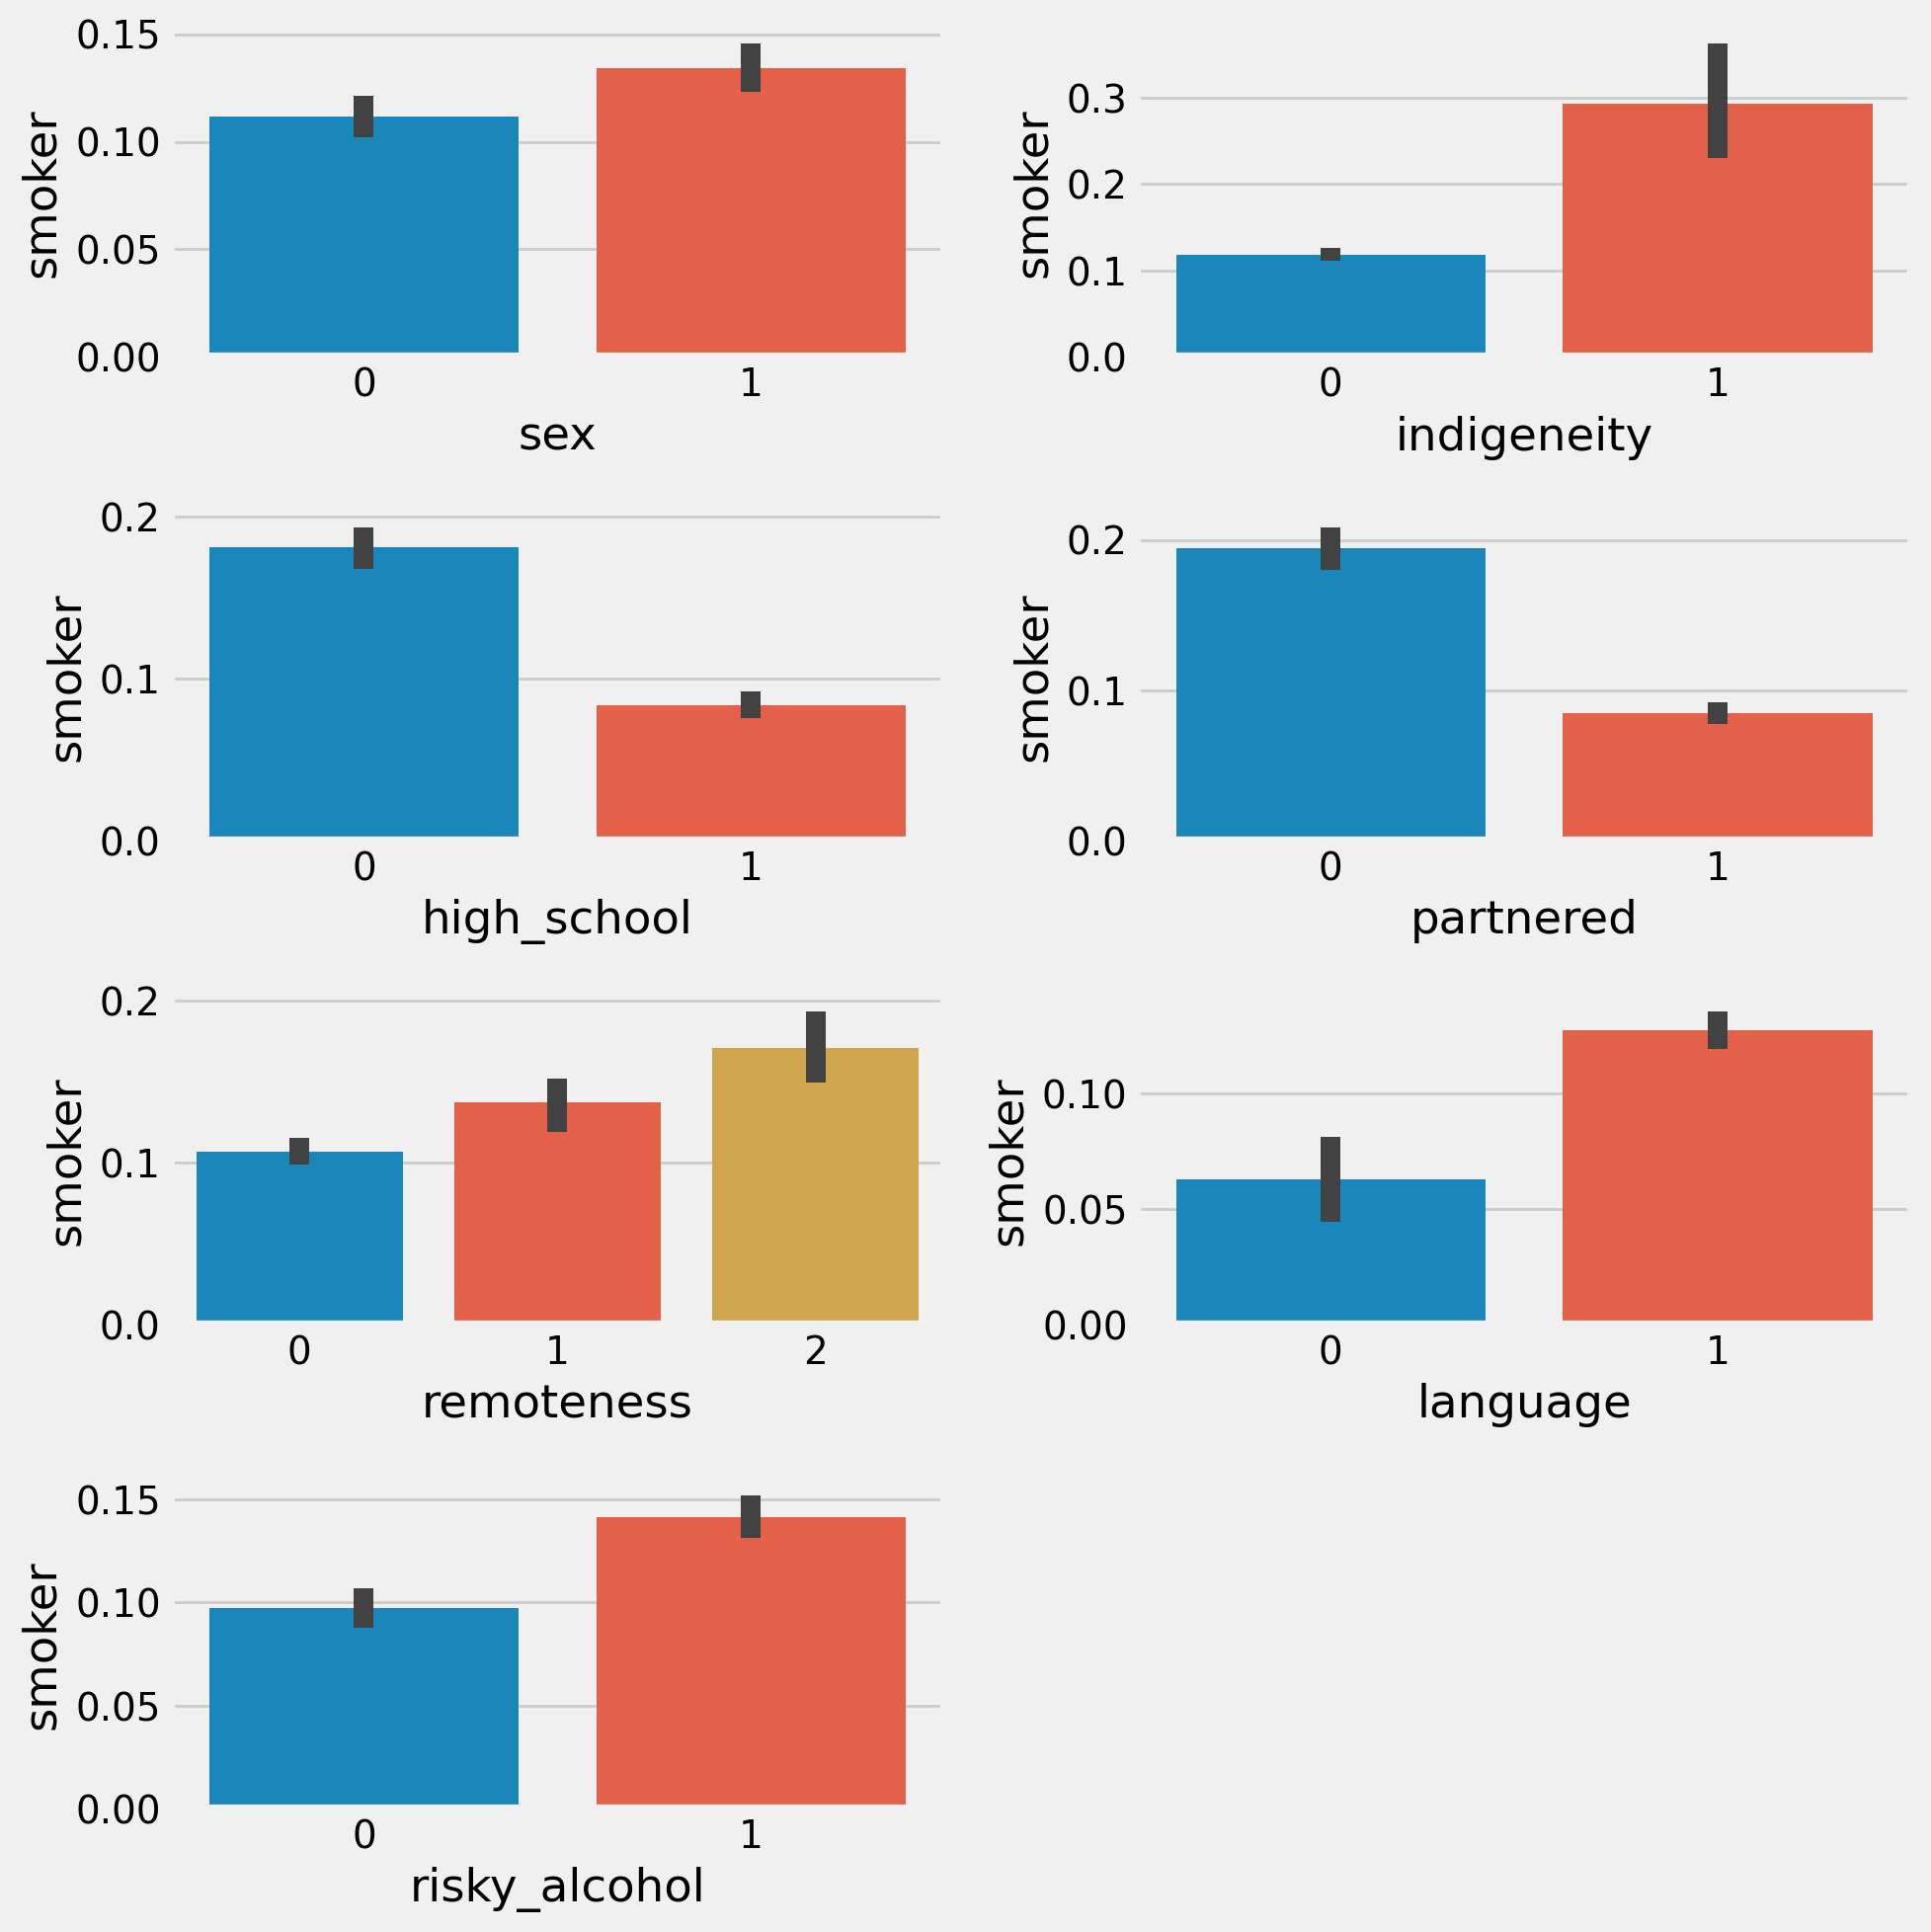

In [7]:
cat_X = [
    c for c in X if c!="age"
]

ncols = 2
nrows = int(np.ceil(len(cat_X) / ncols))

_ = plt.figure(figsize=(10, 10))

for i, x in enumerate(cat_X):
    ax = plt.subplot(nrows, ncols, i+1)
    sns.barplot(data=df, y=T, x=x, ax=ax)

plt.tight_layout()
plt.show()

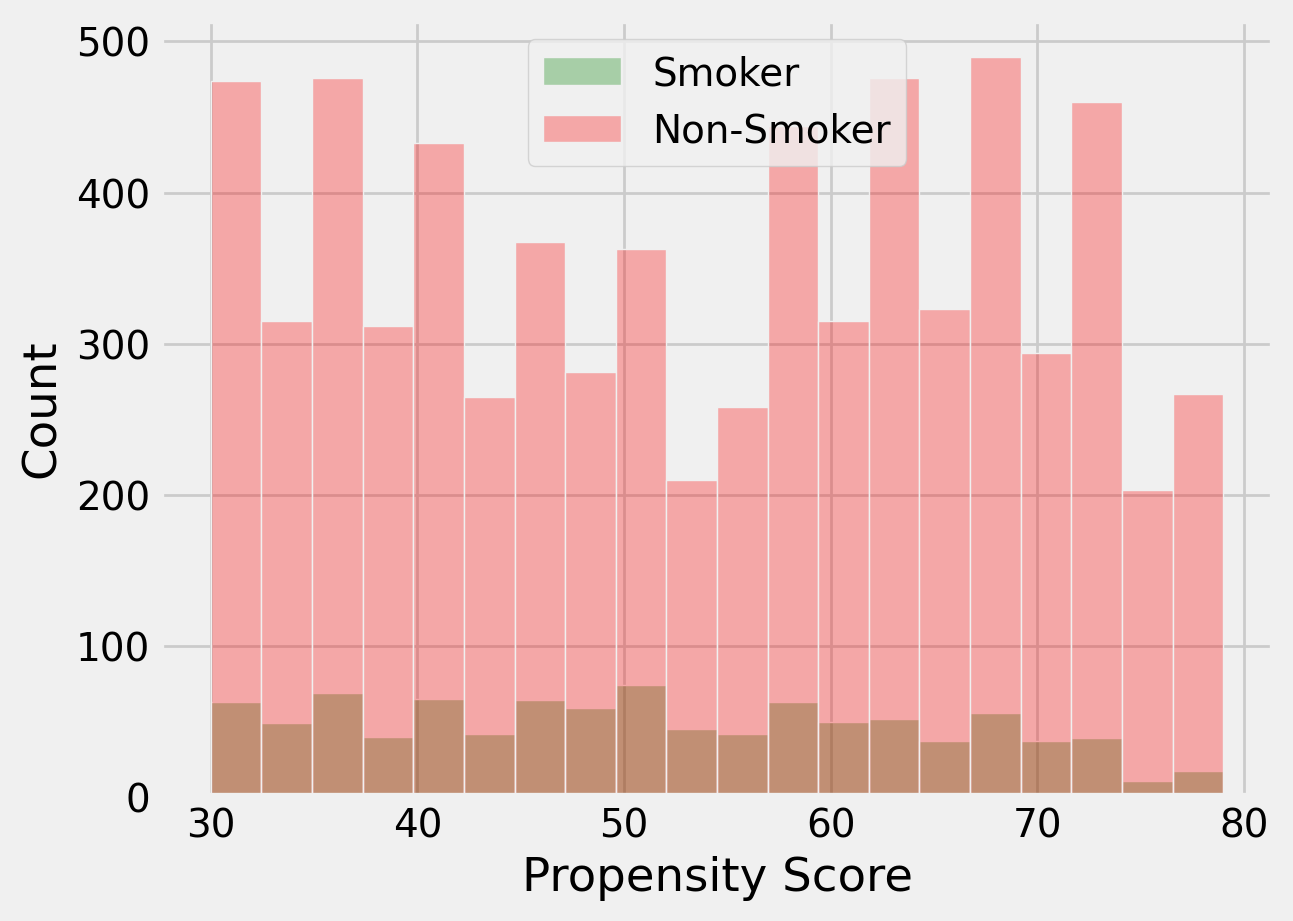

In [8]:
sns.histplot(df.loc[df[T] == 1, "age"], color="green", alpha=0.3, bins=20, label="Smoker", fill=True)
sns.histplot(df.loc[df[T] == 0, "age"], color="red", alpha=0.3, bins=20, label="Non-Smoker", fill=True)
plt.xlabel("Propensity Score")
plt.legend()
plt.show()

### Theoretical Approach Step-By-Step

Let's apply what we've seen in the theoretical introduction.

##### Logistic Regression

First, we need to fit our logistic regression model, in order to obtain the propensity scores.

In [9]:
lr = Pipeline(steps=[
    ("preprocessing", ColumnTransformer(transformers=[
        ("scale", StandardScaler(), ["age"]),
        ("ohe", OneHotEncoder(drop="first", sparse_output=False), ["remoteness"]), 
    ], remainder="passthrough")),
    ("lr", LogisticRegression(C=1e6, random_state=99))
]).fit(df[X], df[T])
ps = lr.predict_proba(df[X])[:, 1]
df = df.assign(ps=ps)

*Checking whether Positivity Assumption holds true*:

In [10]:
df["ps"].describe()

count    8000.000000
mean        0.121750
std         0.087731
min         0.015858
25%         0.059482
50%         0.094642
75%         0.157989
max         0.666112
Name: ps, dtype: float64

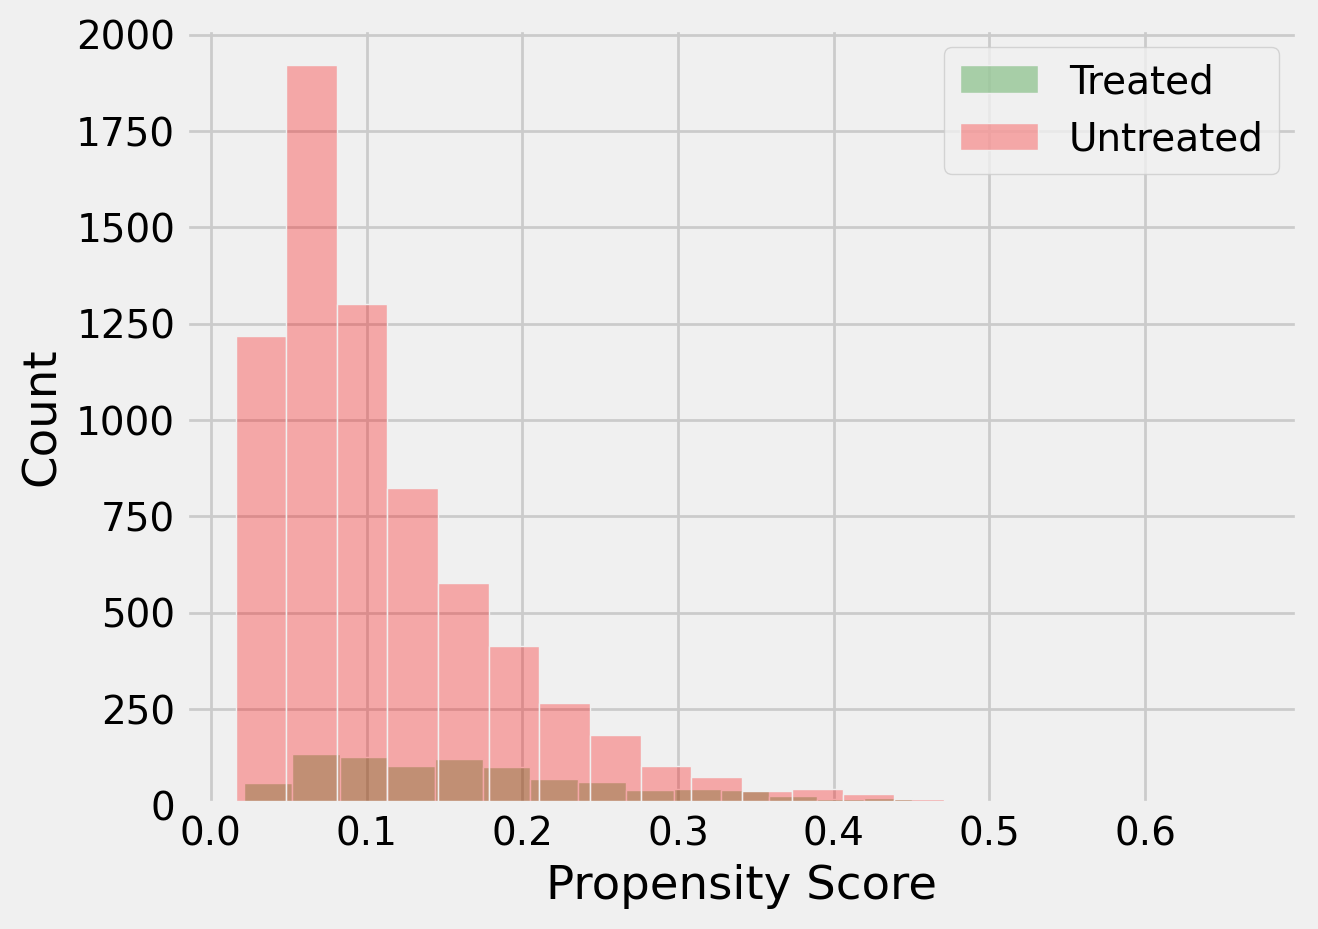

In [11]:
sns.histplot(df.loc[df[T] == 1, "ps"], color="green", alpha=0.3, bins=20, label="Treated", fill=True)
sns.histplot(df.loc[df[T] == 0, "ps"], color="red", alpha=0.3, bins=20, label="Untreated", fill=True)
plt.xlabel("Propensity Score")
plt.legend()
plt.show()

##### Estimating ATE

Given that there is an actual overlap between both distributions, let's check results.

In [12]:
ate = np.mean(
    df[Y] * (df[T] - df["ps"]) / (df["ps"] * (1-df["ps"]))
)
print(f"ATE = {ate:.2f}")

ATE = 1.88


This number by itself tells us nothing, we need an actual confidence interval. You might have realized that this is a tedious job to do analytically. Hence, we will once again rely on **Bootstrapping** to do the job.

In [13]:
from joblib import Parallel, delayed

In [14]:
def estimate_ate_with_matching(
    df, Y, T, X
):
    ps = Pipeline(steps=[
        ("preprocessing", ColumnTransformer(transformers=[
            ("scale", StandardScaler(), ["age"]),
            ("ohe", OneHotEncoder(drop="first", sparse_output=False), ["remoteness"]), 
        ], remainder="passthrough")),
        ("lr", LogisticRegression(C=1e6, random_state=99))
    ]).fit(
        df[X], df[T]
    ).predict_proba(df[X])[:, 1]
    return np.mean(
        df[Y] * (df[T] - ps) / (ps * (1-ps))
    )

In [15]:
np.random.seed(99)

ates = Parallel(n_jobs=2)(
    delayed(estimate_ate_with_matching)(df.sample(frac=1, replace=True), Y, T, X)
    for _ in range(1_000)
)

In [16]:
lower = np.quantile(ates, 0.025)
upper = np.quantile(ates, 0.975)

print(f"({lower:.2f}, {upper:.2f})")

(1.31, 2.49)


### Python package: `causalinference`

Let's take a look at how we can accomplish the same task by using a thirdy party library.

In [17]:
model = CausalModel(
    Y=df[Y].values.squeeze(),
    D=df[T].values.squeeze(),
    X=df[X].values,
)
model.est_via_matching(matches=1, bias_adj=True)
model.estimates

{'matching': {'atc': 1.6003471339319568, 'att': 1.8251080454767186, 'ate': 1.6277117749125316, 'atc_se': 0.43086031661347374, 'att_se': 0.35159482255753527, 'ate_se': 0.40191195433074456}}

### Our approach

In [18]:
from causal_inference.linear import MatchingEstimator

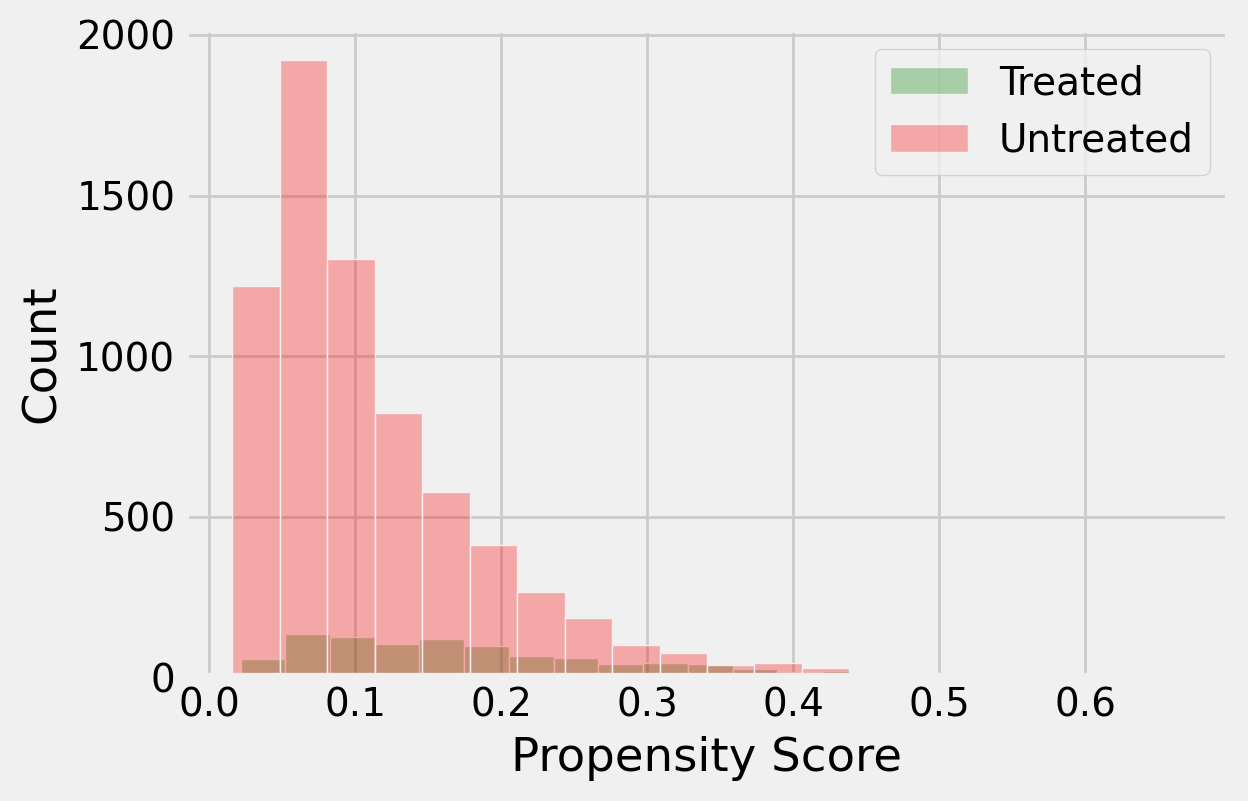

In [19]:
m = MatchingEstimator(
    data=df,
    outcome=Y,
    treatment=T,
    numerical_covariates=["age"],
    categorical_covariates=[c for c in X if c!="age"],
    logistic_regression_regularization=1e6,
)
m.fit(check_distributions=True)

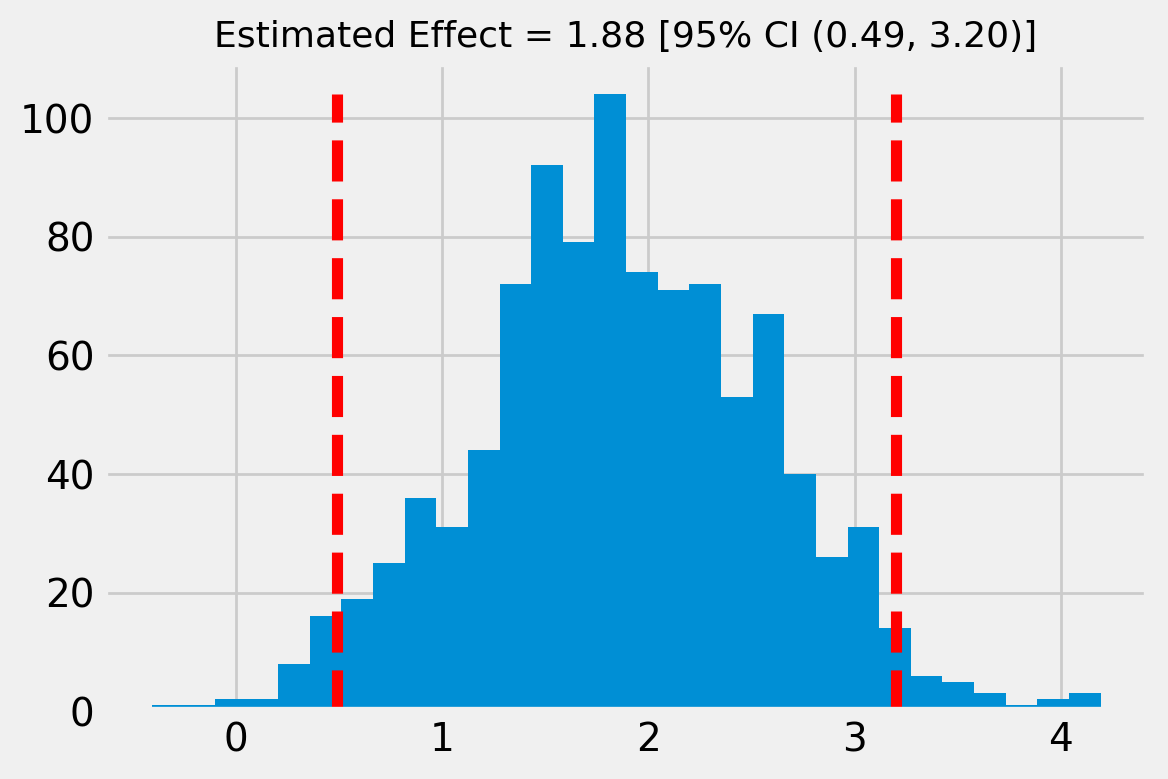

{'ATE': 1.8774, 'CI': (0.48782, 3.20207)}

In [20]:
m.estimate_ate(plot_result=True)